In [4]:
import os
import pickle
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from scipy.interpolate import interp1d
from matplotlib.colors import Normalize
import traceback
import matplotlib.gridspec as gridspec
import StellarDMTracing as sdt

'''
Obviously need SimInfo pickles from Config_dir
Update the newest Merians from update_merians.ipynb
what needs to be run to make this work
Reff and Profiles from ImageCollection, dont think I need to run isophote masking, except maybe for x00y00
StShapes, DMShapes from 3DShapes
smoothed shapes from 3DShapesSmoothing
halotypes from halotypes.py, in the case of Merians they are all simply centrals
masses from get_masses.py
try/except blocks should catch any mismatches, so don't need to worry too much about everything being perfect. 
'''
    
def T(ba,ca):
    return( (1-ba**2)/(1-ca**2) )



In [ ]:


def smooth_and_filter_data(rbins, ba, ca):
    k = 4
    s_factor = 1
    """
    Smooth and filter data, handling a few NaN values gracefully.

    Parameters:
    rbins, ba, ca: array-like, input data
    k: int, degree of the smoothing spline (default 3)
    s_factor: float, smoothing factor as a fraction of len(rbins) (default 0.01)
    residual_threshold, jump_threshold, jump_percentage: unused in this version

    Returns:
    rbins, ba, ca: filtered arrays
    ba_s, ca_s: smoothed spline functions
    """
    import numpy as np
    from scipy.interpolate import UnivariateSpline

    # Remove rows where either ba or ca is NaN
    mask = ~np.isnan(ba) & ~np.isnan(ca)
    rbins_filtered = rbins[mask]
    ba_filtered = ba[mask]
    ca_filtered = ca[mask]

    # Calculate smoothing parameter
    s = s_factor * len(rbins_filtered)

    # Create splines
    ba_s = UnivariateSpline(rbins_filtered, ba_filtered, k=k, s=s)
    ca_s = UnivariateSpline(rbins_filtered, ca_filtered, k=k, s=s)

    # Print some diagnostic information
    # print(f"Total data points: {len(rbins)}")
    # print(f"Data points after NaN removal: {len(rbins_filtered)}")
    # print(f"NaN percentage: {(1 - len(rbins_filtered)/len(rbins))*100:.2f}%")

    n = len(rbins_filtered)
    # calculate residuals and remove outliers
    ba_residuals = ba_filtered - ba_s(rbins_filtered)
    ca_residuals = ca_filtered - ca_s(rbins_filtered)
    # calculate the standard deviation of the residuals
    ba_std = np.std(ba_residuals)
    ca_std = np.std(ca_residuals)
    # remove outliers
    d = 3

    mask = np.abs(ba_residuals) < d * ba_std

    rbins_filtered = rbins_filtered[mask]
    ba_filtered = ba_filtered[mask]
    ca_filtered = ca_filtered[mask]
    mask = np.abs(ca_residuals[mask]) < d * ca_std
    rbins_filtered = rbins_filtered[mask]
    ba_filtered = ba_filtered[mask]
    ca_filtered = ca_filtered[mask]
    # Recreate splines
    ba_s = UnivariateSpline(rbins_filtered, ba_filtered, k=k, s=s)
    ca_s = UnivariateSpline(rbins_filtered, ca_filtered, k=k, s=s)

    # remove any points that are isolated in space
    # calculate the difference between each point

    diff = np.diff(rbins_filtered, prepend=0)
    # print(diff)
    # mask isolated points
    mask = diff > 1
    # print(mask)
    # print(rbins_filtered[mask])
    # print(diff[mask])
    rbins_filtered = rbins_filtered[~mask]
    ba_filtered = ba_filtered[~mask]
    ca_filtered = ca_filtered[~mask]
    # Recreate splines
    ba_s = UnivariateSpline(rbins_filtered, ba_filtered, k=k, s=s)
    ca_s = UnivariateSpline(rbins_filtered, ca_filtered, k=k, s=s)
    # Print some diagnostic information
    # print(f"Data points after outlier removal: {len(rbins_filtered)}")
    # print(f"Outlier percentage: {(1 - len(rbins_filtered)/len(rbins))*100:.2f}%")

    # def clip_function(func):
    #     def clipped(x):
    #         return np.clip(func(x), 0, 1)
    #
    #     return clipped
    #
    # # clip the function to 0,1
    # ba_s_c = clip_function(ba_s)
    # ca_s_c = clip_function(ca_s)

    return rbins_filtered, ba_filtered, ca_filtered, ba_s, ca_s



def nanfunction(x):
    return x*0 +10
#define color scheme to use for plots as a dict


In [ ]:
def main(B_s,C_s,T_s,B_d,C_d,T_d,masses,mb,htype,reff,mvir,feedback_type,label,reff_multi =1):
    data_type = 'all'


    print(len(masses),len(htype))
    #condition0 = (np.log10(10**masses/mvir) < -2)  &  (( C_s >.5 ) & (B_s > .6 )) & (( C_d >.5 ) & (B_d > .6 )) & (masses > 6) & (masses < 9) & (reff < 1)
    #print(sum(condition0))
            
    mb = np.log10(10**masses/mvir)

    

    

    T_diff = np.array((T_d - T_s))
    avg_B = 1#np.average([B_d, B_s], axis=0)
    avg_C = 1#np.average([C_d, C_s], axis=0)
    distances = (np.sqrt(((B_d - B_s) / avg_B) ** 2 + ((C_d - C_s) / avg_C) ** 2))

    #angles = compute_angle_between_ellipsoids(Ed, Es)
    #print(angles[0])



    # Define conditions
    
    #condition1 = (mb < -2)  &  (( C_s >.5 ) & (B_s > .6 )) & (( C_d >.5 ) & (B_d > .6 )) & (masses > 6) & (masses < 9) & (reff < 1)
    #print(sum(condition1))
    #(mb < -1.5) & ((C_s > 0.5) & (B_s > 0.6)) & ((C_d > 0.4) & (B_d > 0.5)) & (masses > 6) & (masses < 9) & (reff < 1)


    
    ### initialize conditions filters ###
    condition = (mb < -2.5)  
    cm = masses
    #condition1 = feedback_type == 'MerianCDM'
    #condition2 = feedback_type == 'BW'
    #condition3 = T_s <.3 
    #condition6 = T_s >.7
    #conditions = [("All", None),('Dark Matter Dominated',condition), ("Merians", condition1), ('DCJL+Marvel',condition2), ('Disky',condition3), ('Prolate',condition6)]
    conditions = [("Marvel+DCJL+Merians", None),]
    #create_histograms(B_s, C_s, T_s, B_d, C_d, T_d, masses, mb, htype, reff, mvir, conditions,reff_multi)
    plt.close()

    # n = len(conditions)
    # rows = n // 2
    # if n % 2 != 0:
    #     rows += 1
    n = 1


    #axes = axes.flatten()
    # mean_T_diff,std_T_diff, mean_distances , std_distances = np.zeros((n)),np.zeros((n)),np.zeros((n)),np.zeros((n))
    # for i, (label, condition) in enumerate(conditions):
    #     print(label)
    #     print(condition)
    #     mean_T_diff[i],std_T_diff[i], mean_distances[i] , std_distances[i] = analyze_distances(T_diff, distances, condition=condition)
    #     plot_data(axes[i], B_s, C_s, T_s, B_d, C_d, T_d, masses, mb, htype, reff, mvir,feedback_type, condition=condition)
    #     axes[i].set_title(label)
    
    sdt.plot_data(B_s, C_s, T_s, B_d, C_d, T_d, masses, mb, htype, reff, mvir, feedback_type, condition=None)
    
    
    # Save the figure
    plt.tight_layout()
    plt.savefig(f'../../Figures/3DShapes/SVQ_hist_combined.{reff_multi}.png', dpi=300)
    #plt.close()
    #print(Ed[0,:,:])
    #plot_ellipsoid_axes(Ed[1,:,:], Es[1,:,:])
    sdt.T_vs_Mstar(T_d,T_s,masses,mb,htype,label)    
    plt.close()
    
    # distances = np.sqrt((B_d - B_s)**2 + (C_d - C_s)**2)
    # plt.figure()
    # plt.scatter(masses,distances)
    # plt.xlabel('Stellar Mass')
    # plt.ylabel('Shape Distance')
    # plt.show()

    return mean_T_diff,std_T_diff, mean_distances, std_distances

    





#r = np.array((.25,.5,.75,1,1.25,1.5,2))
r = np.array((1,))
n = 1
mean_T_diff = np.zeros((n, len(r)))
std_T_diff = np.zeros((n, len(r)))
mean_distances = np.zeros((n, len(r)))
std_distances = np.zeros((n, len(r)))
SimFilePath = ['../PickleFiles/SimulationInfo.BW.pickle','../PickleFiles/SimulationInfo.MerianCDM.pickle']
MassPath = ['../../Data/BasicData/Marvel_DCJL.Masses.pickle','../../Data/BasicData/MerianCDM.Masses.pickle']
HaloTypePath = ['../../Data/BasicData/HaloTypes.txt','../../Data/BasicData/HaloTypes.MerianCDM.txt']
feedback = ['BW','MerianCDM']

for i in range(0, len(r) ):
    
    mean_T_diff[:,i],std_T_diff[:,i], mean_distances[:,i] , std_distances[:,i] = main(B_s,C_s,T_s,B_d,C_d,T_d,masses,mb,htype,reff,mvir,feedback_type,label = 'CDM',reff_multi = r[i])

#mean_T_diff[:,i],std_T_diff[:,i], mean_distances[:,i] , std_distances[:,i] = main(r[i])
#plt.errorbar(r,mean_T_diff,std_T_diff)
#plt.errorbar(r,mean_distances,std_distances)

In [ ]:
feedbacks = ['BWMDC', 'MerianCDM']
#feedbacks = [ 'MerianCDM']

import importlib
importlib.reload(sdt)
B_s,C_s,T_s,B_d,C_d,T_d,masses,mb,mb_reff,mb_10rvir,htype,reff,mvir,feedback_type,sims,hids,mergers,rvir,diffs_at_reff, jz_jcirc_avgs,t_dyn = sdt.LoadSimData(feedbacks,return_sims=True,reff_multi=1)


#print len of number of b_d, c_d, b_s, c_s = 10
print(len(B_s[B_s == 10]),len(C_s[C_s == 10]),len(B_d[B_d == 10]),len(C_d[C_d == 10]))

#remove unphysical values where c > b
mask = C_s > B_s
B_s = B_s[~mask]
C_s = C_s[~mask]
T_s = T_s[~mask]
B_d = B_d[~mask]
C_d = C_d[~mask]
T_d = T_d[~mask]
masses = masses[~mask]
mb = mb[~mask]
mb_reff = mb_reff[~mask]
mb_10rvir = mb_10rvir[~mask]
htype = htype[~mask]
reff = reff[~mask]
mvir = mvir[~mask]
feedback_type = feedback_type[~mask]
sims = sims[~mask]
hids = hids[~mask]
#mergers = mergers[~mask]
rvir = rvir[~mask]
diffs_at_reff = diffs_at_reff[~mask]
jz_jcirc_avgs = jz_jcirc_avgs[~mask]
t_dyn = t_dyn[~mask]
#print(len(sims))

print(len(sims))

#create histograms of mb,mb_reff,mb_10rvir
#plot histograms of mb,mb_reff,mb_10rvir
#create histograms of mb, mb_reff, mb_10rvir with outline only

#split into marvel, DCJL, Merians
#marvel is composed of sims with names cptmarvel,storm,rogue,elektra,
#DCJL is composed of sims with names h148 h229 h242 h329
#Merians have sim names like r with a number following it

In [ ]:
print(sims,masses,B_d)

In [ ]:

#create marvel mask
marvel_mask = np.zeros(len(sims),dtype=bool)
for sim in ['cptmarvel','storm','rogue','elektra']:
    marvel_mask[sims == sim] = True

print(sims[marvel_mask])
#DCJL mask
DCJL_mask = np.zeros(len(sims),dtype=bool)
for sim in ['h148','h229','h242','h329']:
    DCJL_mask[sims == sim] = True
print(sims[DCJL_mask])

#Merians mask
Merians_mask = np.zeros(len(sims),dtype=bool)
for sim in sims:
    if sim[0] == 'r':
        Merians_mask[sims == sim] = True
    if sim == 'rogue':
        Merians_mask[sims == sim] = False
print(sims[Merians_mask])



In [ ]:



import matplotlib.pyplot as plt
import numpy as np

def plot_histograms_with_masks(mb, mb_reff, mb_10rvir, feedback_type, masks_labels):
    fig, axes = plt.subplots(2, 2, figsize=(16, 8))
    #flatten axes
    axes = axes.flatten()
    bins = np.logspace(-4, 0, 50).tolist()
    lw = 2

    for ax, (mask, label) in zip(axes, masks_labels):
        ax.hist(mb[mask], bins=bins, alpha=1, label=f'Baryonic fraction within virial radius ({label})', histtype='step', lw=lw)
        ax.hist(mb_reff[mask], bins=bins, alpha=1, label=f'Baryonic fraction within effective radius ({label})', histtype='step', lw=lw)
        ax.hist(mb_10rvir[mask], bins=bins, alpha=1, label=f'Baryonic fraction within 10% of virial radius ({label})', histtype='step', lw=lw)
        ax.set_xlabel(r'f$_b$')
        ax.set_ylabel('Number of Galaxies')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.legend()
        ax.set_title(label)

    plt.tight_layout()
    plt.show()

# Example usage:
masks_labels = [(marvel_mask, 'Marvel'), (DCJL_mask, 'DCJL'), (Merians_mask, 'Merians'), (np.ones(len(sims),dtype=bool), 'All')]
#plot_histograms_with_masks(mb, mb_reff, mb_10rvir, feedback_type, masks_labels)




#mask out disk galaxies
#list of sims halos with disk galaxies
# disk_sims_pickle = 'disk_sims_results.pickle'
#
# disk_sims = pickle.load(open(disk_sims_pickle,'rb'))
disk_sims = {}
for feedback in feedbacks:
    # with open(f'galaxy_classifications_{feedback}.pickle', 'wb') as f:
    #     pickle.dump(classified_galaxies, f)
    try:
        with open(f'galaxy_classifications_{feedback}.pickle', 'rb') as f:
            classified_galaxies = pickle.load(f)
            disk_sims.update(classified_galaxies)
    except FileNotFoundError:
        print(f'File galaxy_classifications_{feedback}.pickle not found')
        continue


#combine all classified galaxies


print(hids)
mask = np.zeros(len(sims), dtype=bool)
disk_mask = np.zeros(len(sims), dtype=bool)
ellip_mask = np.zeros(len(sims), dtype=bool)
irr_mask = np.zeros(len(sims), dtype=bool)

for sim in disk_sims:
    for halo in disk_sims[sim]:
        disk_sim = disk_sims[sim][halo]
        # Find indices where both sims and hids match the current sim and halo
        indices = (sims == sim) & (hids == halo)
        print(sim, halo, disk_sim)
        if disk_sim == 'd':
            disk_mask[indices] = True
        elif disk_sim == 'i':
            irr_mask[indices] = True
        elif disk_sim == 'e':
            ellip_mask[indices] = True
        else:
            print('Error: disk_sim not recognized')
            print(sim, halo)
            print(disk_sim)
            break


print(sum(disk_mask),sum(ellip_mask),sum(irr_mask),sum(disk_mask)+sum(ellip_mask)+sum(irr_mask),len(sims))
#print(mask)
import importlib
importlib.reload(sdt)
from StellarDMTracing import colors
#sdt.plot_data_with_disky(B_s, C_s, T_s, B_d, C_d, T_d, masses, mb, htype, reff, mvir, feedback_type, mask,
                         #mergers=None, show_lines=True, show_scatter=True)

# #check with jz_jcirc_avgs
# #plot histogram of jz_jcirc_avgs
# fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# bins = np.linspace(-.25, .5, 15)
# #ax.hist(jz_jcirc_avgs, bins=bins, alpha=.5, label='All Galaxies', color='k', histtype='step', lw=2)
# ax.hist(jz_jcirc_avgs[disk_mask], bins=bins, alpha=.5, label='Disk Galaxies', color='g', histtype='step', lw=2)
# ax.hist(jz_jcirc_avgs[ellip_mask], bins=bins, alpha=.5, label='Elliptical Galaxies', color='r', histtype='step', lw=2)
# ax.set_yscale('log')
# ax.set_xlabel('Average Jz/Jcirc')
# ax.set_ylabel('Number of Galaxies')
# ax.legend()
# plt.show()
#



In [ ]:
#add column to dataframe for galaxy classification that is 'disk', 'elliptical', 'irregular'
#based on disk_mask, ellip_mask, irr_mask
#add empty column to dataframe
import pandas as pd
import numpy as np

# Example data dictionary
data = {
    'sims': sims,
    'hids': hids,
    'B_s': B_s,
    'C_s': C_s,
    'T_s': T_s,
    'B_d': B_d,
    'C_d': C_d,
    'T_d': T_d,
    'Stellar mass': 10**masses,
    'mb': mb,
    'mb_reff': mb_reff,
    'mb_10rvir': mb_10rvir,

    'reff': reff,
    'mvir': mvir,


    'rvir': rvir,
    #'diffs_at_reff': [tuple(row) for row in diffs_at_reff],  # Convert to list of tuples
    'jz_jcirc_avgs': jz_jcirc_avgs,
    't_dyn': t_dyn,
    'C_dm/C_star': C_d/C_s,
    'B_dm/B_star': B_d/B_s,
    'T_dm - T_star': T_d - T_s,

    'galaxy_class': np.zeros(len(sims),dtype=object),
    'feedback_type': feedback_type,
    'htype': htype,
}



#set galaxy classification based on masks
data['galaxy_class'][disk_mask] = 'disk'
data['galaxy_class'][ellip_mask] = 'elliptical'
data['galaxy_class'][irr_mask] = 'irregular'

#add C_dm/C_star and B_dm/B_star columns to dataframe



# Convert all data to pandas dataframe
df = pd.DataFrame(data)
df = df.sort_values(['sims', 'hids'])



In [ ]:
#save dataframe to pickle file
df.to_pickle('../../Data/BasicData/3DShapesDataframeNew.pickle')
#read dataframe from pickle file
#df = pd.read_pickle('../../Data/BasicData/3DShapesDataframe.pickle')


In [5]:

# add ../ to path
import sys
import os
import importlib
sys.path.append('/home/bk639/MorphologyMeasurements/Code')

In [14]:
#show paths added to sys.path
print(sys.path)

['/home/blake/.local/share/JetBrains/Toolbox/apps/pycharm-professional/plugins/python/helpers-pro/jupyter_debug', '/home/blake/.local/share/JetBrains/Toolbox/apps/pycharm-professional/plugins/python-ce/helpers/pydev', '/home/bk639/MorphologyMeasurements/Code/IntrinsicShapes', '/home/bk639/miniconda3/envs/shapes/lib/python312.zip', '/home/bk639/miniconda3/envs/shapes/lib/python3.12', '/home/bk639/miniconda3/envs/shapes/lib/python3.12/lib-dynload', '', '/home/bk639/miniconda3/envs/shapes/lib/python3.12/site-packages', '/home/bk639/MorphologyMeasurements/Code', '/home/bk639/MorphologyMeasurements/Code']


In [15]:
#disk classifcation by shape at 2Reff
feedbacks = ['BWMDC', 'MerianCDM']
for reff_multi in [2]:
    B_s,C_s,T_s,B_d,C_d,T_d,masses,mb,mb_reff,mb_10rvir,htype,reff,mvir,feedback_type,sims,hids,mergers,rvir,diffs_at_reff, jz_jcirc_avgs,t_dyn = sdt.LoadSimData(feedbacks,return_sims=True,reff_multi=reff_multi)



    #recreate disk_mask for galaxies where C_s < .4, and T_s < 0.6

    mask = (C_s < .4) & (B_s > .65)
    disks_mask = mask
    ellip_mask = ~mask


    #compare to old method
    #print(f'number in sample at reff_multi {reff_multi}: {len(sims)}')
    disk_sims = {}
    for feedback in feedbacks:
        # with open(f'galaxy_classifications_{feedback}.pickle', 'wb') as f:
        #     pickle.dump(classified_galaxies, f)
        try:
            with open(f'galaxy_classifications_{feedback}.pickle', 'rb') as f:
                classified_galaxies = pickle.load(f)
                disk_sims.update(classified_galaxies)
        except FileNotFoundError:
            print(f'File galaxy_classifications_{feedback}.pickle not found')
            continue


    #combine all classified galaxies


    mask = np.zeros(len(sims), dtype=bool)
    disk_mask = np.zeros(len(sims), dtype=bool)
    ellip_mask = np.zeros(len(sims), dtype=bool)
    irr_mask = np.zeros(len(sims), dtype=bool)

    for sim in disk_sims:
        for halo in disk_sims[sim]:
            disk_sim = disk_sims[sim][halo]
            # Find indices where both sims and hids match the current sim and halo
            indices = (sims == sim) & (hids == halo)
            #print(sim, halo, disk_sim)
            # if masses[indices] < 7.5:
            #     disk_sim = 'e'
            if disk_sim == 'd':
                disk_mask[indices] = True
            elif disk_sim == 'i':
                irr_mask[indices] = True
            elif disk_sim == 'e':
                ellip_mask[indices] = True
            else:
                print('Error: disk_sim not recognized')
                print(sim, halo)
                print(disk_sim)
                break
    n_diff = 0
    for i in range(len(sims)):
        if disks_mask[i] != disk_mask[i]:
            print(f'sims: {sims[i]}, hids: {hids[i]}, new: {disks_mask[i]}, old: {disk_mask[i]}')
            print(f'C_s: {C_s[i]}, T_s: {T_s[i]}')
            n_diff += 1
    print(f'number of differences at reff_multi {reff_multi}: {n_diff}')
    
    #print sims with c_s < .4, and t_s > .666
    for i in range(len(sims)):
        if C_s[i] < .4 and T_s[i] > .666:
            print(f'sims: {sims[i]}, hids: {hids[i]}, C_s: {C_s[i]:.2f}, B_s: {B_s[i]:.2f}, T_s: {T_s[i]:.2f}, mass {masses[i]:.2f}')

disk_mask = None
ellip_mask = None
irr_mask = None


['../PickleFiles/SimulationInfo.BWMDC.pickle', '../PickleFiles/SimulationInfo.MerianCDM.pickle']
sims: cptmarvel, hids: 2, new: True, old: False
C_s: 0.24498263102892504, T_s: 0.09307188787769272
sims: elektra, hids: 3, new: False, old: True
C_s: 0.35306514489713375, T_s: 0.7291478789249586
sims: rogue, hids: 8, new: False, old: True
C_s: 0.5616243347468756, T_s: 0.3232397533340234
sims: h229, hids: 2, new: False, old: True
C_s: 0.5223841992493716, T_s: 0.16759176261988848
sims: r753, hids: 1, new: False, old: True
C_s: 0.40707953862582125, T_s: 0.40516692948664695
sims: r918, hids: 1, new: False, old: True
C_s: 0.4229002243750767, T_s: 0.299559077505445
number of differences at reff_multi 2: 6
sims: cptmarvel, hids: 3, C_s: 0.39, B_s: 0.63, T_s: 0.71, mass 6.93
sims: elektra, hids: 3, C_s: 0.35, B_s: 0.60, T_s: 0.73, mass 7.60
sims: elektra, hids: 4, C_s: 0.39, B_s: 0.47, T_s: 0.91, mass 7.78
sims: r563, hids: 1, C_s: 0.34, B_s: 0.59, T_s: 0.73, mass 8.61
sims: r615, hids: 1, C_s: 0.3

['../PickleFiles/SimulationInfo.BWMDC.pickle', '../PickleFiles/SimulationInfo.MerianCDM.pickle']

All data:
B: statistic=0.34, p-value=1.95e-04
C: statistic=0.59, p-value=3.92e-13

non-disky galaxies:
B: statistic=0.17, p-value=4.94e-01
C: statistic=0.33, p-value=1.45e-02

disky galaxies:
B: statistic=0.62, p-value=2.20e-06
C: statistic=1.00, p-value=7.03e-20
number of disk galaxies at reff_multi 2: 34
number of non-disk galaxies at reff_multi 2: 46
number of central galaxies: 65
number of satellite galaxies: 15
number of disk satellite galaxies: 4


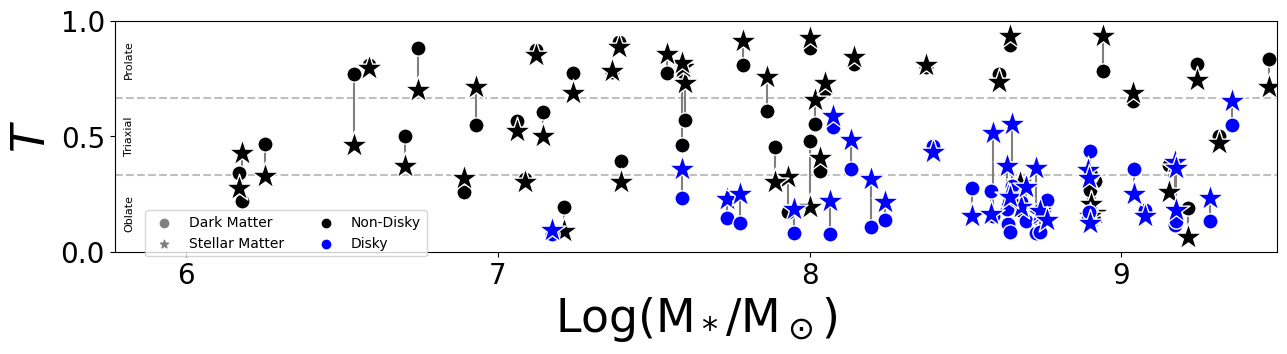

In [27]:

import numpy as np
from scipy import stats
import PlotClasses
#display classes in PlotClasses
#print(dir(PlotClasses))
#reload(PlotClasses)
importlib.reload(PlotClasses)
importlib.reload(sdt)

feedbacks = ['BWMDC', 'MerianCDM']
for reff_multi in [2]:
    B_s,C_s,T_s,B_d,C_d,T_d,masses,mb,mb_reff,mb_10rvir,htype,reff,mvir,feedback_type,sims,hids,mergers,rvir,diffs_at_reff, jz_jcirc_avgs,t_dyn = sdt.LoadSimData(feedbacks,return_sims=True,reff_multi=reff_multi)

    # #remove higher mass galaxies from the sample
    # mass_threshold = 8.5
    # mask = masses < mass_threshold
    # B_s = B_s[~mask]
    # C_s = C_s[~mask]
    # T_s = T_s[~mask]
    # B_d = B_d[~mask]
    # C_d = C_d[~mask]
    # T_d = T_d[~mask]
    # masses = masses[~mask]
    # mb = mb[~mask]
    # mb_reff = mb_reff[~mask]
    # mb_10rvir = mb_10rvir[~mask]
    # htype = htype[~mask]
    # reff = reff[~mask]
    # mvir = mvir[~mask]
    # feedback_type = feedback_type[~mask]
    # sims = sims[~mask]
    # hids = hids[~mask]
    # #mergers = mergers[~mask]
    # rvir = rvir[~mask]
    # diffs_at_reff = diffs_at_reff[~mask]
    # jz_jcirc_avgs = jz_jcirc_avgs[~mask]
    # t_dyn = t_dyn[~mask]
    # masks = {'non-disky': ~disks_mask[~mask], 'disky': disks_mask[~mask]}
    masks = {'non-disky': ~disks_mask, 'disky': disks_mask}



    def perform_ks_tests(B_s, B_d, C_s, C_d, mask=None):
        if mask is None:
            mask = np.ones_like(B_s, dtype=bool)

        # Perform KS tests
        ks_B = stats.ks_2samp(B_s[mask], B_d[mask])
        ks_C = stats.ks_2samp(C_s[mask], C_d[mask])

        return {
            'B_statistic': ks_B.statistic,
            'B_pvalue': ks_B.pvalue,
            'C_statistic': ks_C.statistic,
            'C_pvalue': ks_C.pvalue
        }

    # Test the function
    results_all = perform_ks_tests(B_s, B_d, C_s, C_d)
    print("\nAll data:")
    print(f"B: statistic={results_all['B_statistic']:.2f}, p-value={results_all['B_pvalue']:.2e}")
    print(f"C: statistic={results_all['C_statistic']:.2f}, p-value={results_all['C_pvalue']:.2e}")

    # Test with masks
    for mask_name, mask in masks.items():
        results = perform_ks_tests(B_s, B_d, C_s, C_d, mask)
        print(f"\n{mask_name} galaxies:")
        print(f"B: statistic={results['B_statistic']:.2f}, p-value={results['B_pvalue']:.2e}")
        print(f"C: statistic={results['C_statistic']:.2f}, p-value={results['C_pvalue']:.2e}")



    #disk_mask = (C_s < .4) & (T_s < .666)
    





    #print(len(sims))
    

    #recreate disk_mask for galaxies where C_s < .4, and T_s < 0.6

    print(f'number of disk galaxies at reff_multi {reff_multi}: {sum(disks_mask)}')
    print(f'number of non-disk galaxies at reff_multi {reff_multi}: {sum(~disks_mask)}')


           



    #Usage example:
    folder = '/home/bk639/OverLeaf/ShapePaper/'
    data_plot = {
        'B_s': B_s, 'C_s': C_s, 'T_s': T_s, 'B_d': B_d, 'C_d': C_d, 'T_d': T_d,
        'masses': masses, 'mb': mb, 'htype': htype, 'reff': reff, 'mvir': mvir,'reff_multi':reff_multi,
        'diffs_at_reff': diffs_at_reff, 'halo_id': hids

    }
    masks = {'non-disky': ~disks_mask, 'disky': disks_mask}
    labels = {'non-disky': 'Non-Disky', 'disky': 'Disky', 'B': 'Q', 'C': 'S'}
    colors = {'non-disky': 'k', 'disky': 'blue'}


    #save data and masks to pickle file
    with open(f'../../Data/BasicData/3DShapesData.{reff_multi}.pickle', 'wb') as f:
        pickle.dump((data_plot, masks, labels), f)


    plotter = PlotClasses.GeneralPlotter(data_plot, masks, labels, colors)
    plotter.plot_KF_data = True
    #plotter.plot_regression = True
    #plotter.plot_data_with_masks('B', 'C', show_lines=True, show_scatter=True, filename=folder +  f'SvQ_disky.{reff_multi}.png')
    #plotter.plot_Mstar_V_QvS(filename=folder + f'Mstar_V_QvS_disky.{reff_multi}.png')
    #plotter.plot_Mstar_V_b_d_b_s_V_c_d_c_s(filename= folder + f'Mstar_V_b_d_b_s_V_c_d_c_s_disky.{reff_multi}.png')
    #plotter.calculate_shape_diff()
    plotter.plot_triaxiality_vs_mass(filename=folder + f'T_vs_Mass_disky.{reff_multi}.png')
    #plotter.plot_T_stellar_vs_dark(filename=folder + f'T_stellar_vs_dark_matter_disky.{reff_multi}.png')

    #plotter.plot_q_s_q_d(filename=folder + f'q_s_q_d_and_s_s_s_d.{reff_multi}.png')

    #plotter.plot_triaxiality_histograms(filename=folder + f'Triaxiality_histograms_disky.{reff_multi}.png')
    # if reff_multi == 2:
    #     plotter.plot_angle_distributions(filename=folder + f'angle_distributions.{reff_multi}.png')


    #craete plot based on htype, either satellite or central
    central_mask = htype == 'o'
    satellite_mask = htype == 'v'

    #create masks for galaxies that are both satellite and disky
    disk_satellite_mask = disks_mask & satellite_mask

    masks = {'central': central_mask, 'satellite': satellite_mask, 'disky satellite': disk_satellite_mask}
    labels = {'central': 'Central', 'satellite': 'Satellite', 'disky satellite': 'Disky Satellite', 'B': 'Q', 'C': 'S'}

    print(f'number of central galaxies: {sum(central_mask)}')
    print(f'number of satellite galaxies: {sum(satellite_mask)}')
    print(f'number of disk satellite galaxies: {sum(disk_satellite_mask)}')

    colors = {'central': 'k', 'satellite': 'green', 'disky satellite': 'lightseagreen'}
    plotter = PlotClasses.GeneralPlotter(data_plot, masks, labels, colors)
    #plotter.plot_KF_data = False
    # plotter.plot_data_with_masks('B', 'C', show_lines=True, show_scatter=True, filename=folder + f'SvQ_central_satellite.{reff_multi}.png')
    # plotter.calculate_shape_diff()
    # plotter.plot_triaxiality_vs_mass(filename=folder + f'T_vs_Mass_central_satellite.{reff_multi}.png')
    # plotter.plot_T_stellar_vs_dark(filename=folder + f'T_stellar_vs_dark_matter_central_satellite.{reff_multi}.png')
    #plotter.plot_Mstar_V_b_d_b_s_V_c_d_c_s(filename= folder + f'Mstar_V_b_d_b_s_V_c_d_c_s_central_satellite.{reff_multi}.png')
    # plotter.plot_q_s_q_d(filename=folder + f'q_s_q_d_and_s_s_s_d_central_satellite.{reff_multi}.png')
    # plotter.plot_Mstar_V_QvS(filename=folder + f'Mstar_V_QvS_central_satellite.{reff_multi}.png')
    # if reff_multi == 2:
    #     plotter.plot_angle_distributions(filename=folder + f'angle_distributions_central_satellite.{reff_multi}.png')









2DShapeProjection.py
3DShapeCollection.Dark.py
3DShapeCollection.py
3DShapeCollection.Stars.py
3DShapeSmoothing.py
disk_sims_results.pickle
EllipticityComparison.py
feedback_statistics.csv
GalaCollector.py
galaxy_classifications_BWMDC.pickle
galaxy_classifications_MerianCDM.pickle
galaxy_classifications_MerianSIDM.pickle
galaxy_classifications_SIDM_CDM_comparison.pickle
GalaxyClass.ipynb
halo_check_progress.pickle
halo_differences.csv
Merger_shapes_plots.ipynb
MergerShapes.py
NinBins.ipynb
Orientations.ipynb
PlotCDMvsSIDM.ipynb
__pycache__/
ShapeExamples.ipynb
Shape_testing.ipynb
ShapeTestPlot.ipynb
SIDM_CDM_Shapes.ipynb
SIDM_central_densities.ipynb
stats.ipynb
StellarDM_SIDM_CDM.ipynb
StellarDMTracing.ipynb
StellarDMTracing.py
Storm_DM_Shapes.ipynb
Storm_DM_Shapes.ipynb.invalid
Untitled.ipynb
View_disks.ipynb


Non-Disky galaxies: B_D/B_* mean: 1.12, std: 0.14
Disky galaxies: B_D/B_* mean: 1.17, std: 0.14
Non-Disky galaxies: C_D/C_* mean: 1.29, std: 0.25
Disky galaxies: C_D/C_* mean: 2.05, std: 0.53
Non-Disky galaxies: T_D/T_* mean: 1.05, std: 0.42
Disky galaxies: T_D/T_* mean: 0.82, std: 0.38


Non-Disky galaxies: B_D/B_* mean: 1.06, std: 0.10
Disky galaxies: B_D/B_* mean: 1.10, std: 0.09
Non-Disky galaxies: C_D/C_* mean: 1.21, std: 0.20
Disky galaxies: C_D/C_* mean: 2.13, std: 0.62
Non-Disky galaxies: T_D/T_* mean: 1.16, std: 0.47
Disky galaxies: T_D/T_* mean: 0.83, std: 0.60




In [ ]:
# sort sims,hids, by mass
masses = 10**masses
sorted_indices = np.argsort(masses)
masses = masses[sorted_indices]
sims = sims[sorted_indices]
hids = hids[sorted_indices]

In [ ]:
for i in range(len(sims)):
    print(f'sims: {sims[i]}, hids: {hids[i]}, mass: {masses[i]:.2e}')

In [ ]:
#how many sattelite galaxies are also non-disky
n_same = 0
n_diff = 0
for i in range(len(sims)):
    if satellite_mask[i] and ~disk_mask[i]:
        print(f'sims: {sims[i]}, hids: {hids[i]}')
        n_same += 1
    elif satellite_mask[i] and disk_mask[i]:
        n_diff += 1
print(f'number both sat, and disky: {n_same}')
print(f'number sat, not disky: {n_diff}')


['../PickleFiles/SimulationInfo.BWMDC.pickle', '../PickleFiles/SimulationInfo.SBMarvel.pickle']
Error loading diff_at_Reff for sim storm halo 1
Error loading jz_jcirc_avg for sim storm halo 1
Error loading diff_at_Reff for sim storm halo 2
Error loading jz_jcirc_avg for sim storm halo 2
Error loading diff_at_Reff for sim storm halo 3
Error loading jz_jcirc_avg for sim storm halo 3
Error loading diff_at_Reff for sim storm halo 4
Error loading jz_jcirc_avg for sim storm halo 4
Error loading diff_at_Reff for sim storm halo 5
Error loading jz_jcirc_avg for sim storm halo 5
Error loading diff_at_Reff for sim storm halo 6
Error loading jz_jcirc_avg for sim storm halo 6
Error loading diff_at_Reff for sim storm halo 7
Error loading jz_jcirc_avg for sim storm halo 7
Error loading diff_at_Reff for sim storm halo 8
Error loading jz_jcirc_avg for sim storm halo 8
sim storm halo 14 has invalid shape values
ba_s: 0.9360794214797974, ca_s: 0.4907253099214839, ba_d: 1.0293596904574154, ca_d: 0.2888325

/home/bk639/miniconda3/envs/shapes/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


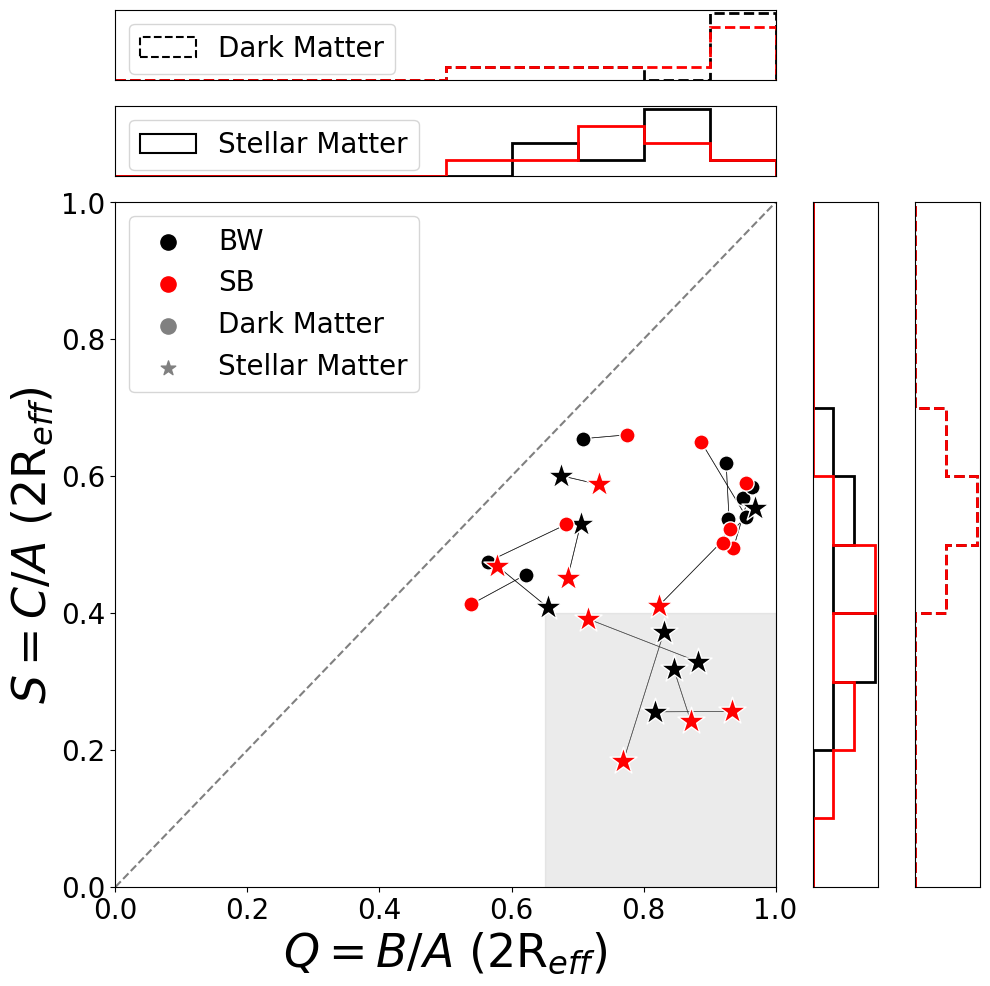

In [194]:
import pandas as pd
import numpy as np
#reload sdt
import importlib
importlib.reload(sdt)
importlib.reload(PlotClasses)

feedbacks = ['BWMDC', 'SBMarvel']


def analyze_feedback_differences(B_s, C_s, T_s, B_d, C_d, T_d, masses, reff, mvir, rvir,
                               hids, feedback_type, feedbacks):
    # Create DataFrame for per-halo differences
    halo_diffs = []

    for halo in np.unique(hids):
        mask = hids == halo
        if np.sum(mask) == 2:  # Only compare when we have both feedback types
            diff_dict = {
                'halo_id': halo,
                'mass': masses[mask],  # Taking first value since they're same halo
                'reff': reff[mask],
                'mvir': mvir[mask],
                'rvir': rvir[mask],
                'B_s_diff': (B_s[mask][0] - B_s[mask][1]),
                'C_s_diff': (C_s[mask][0] - C_s[mask][1]),
                'T_s_diff': (T_s[mask][0] - T_s[mask][1]),
                'B_d_diff': (B_d[mask][0] - B_d[mask][1]),
                'C_d_diff': (C_d[mask][0] - C_d[mask][1]),
                'T_d_diff': (T_d[mask][0] - T_d[mask][1])
            }
            halo_diffs.append(diff_dict)

    # Create DataFrame for feedback type statistics
    feedback_stats = []

    for feedback in feedbacks:
        mask = feedback_type == feedback
        stats_dict = {
            'feedback_type': feedback,
            'B_s_mean': np.mean(B_s[mask]),
            'B_s_std': np.std(B_s[mask]),
            'C_s_mean': np.mean(C_s[mask]),
            'C_s_std': np.std(C_s[mask]),
            'T_s_mean': np.mean(T_s[mask]),
            'T_s_std': np.std(T_s[mask]),
            'B_d_mean': np.mean(B_d[mask]),
            'B_d_std': np.std(B_d[mask]),
            'C_d_mean': np.mean(C_d[mask]),
            'C_d_std': np.std(C_d[mask]),
            'T_d_mean': np.mean(T_d[mask]),
            'T_d_std': np.std(T_d[mask])
        }
        feedback_stats.append(stats_dict)

    # KS test to see if distriubutions are different between feedback types
    ks_B = stats.ks_2samp(B_s[feedback_type == feedbacks[0]], B_s[feedback_type == feedbacks[1]])
    ks_C = stats.ks_2samp(C_s[feedback_type == feedbacks[0]], C_s[feedback_type == feedbacks[1]])
    ks_T = stats.ks_2samp(T_s[feedback_type == feedbacks[0]], T_s[feedback_type == feedbacks[1]])
    ks_B_d = stats.ks_2samp(B_d[feedback_type == feedbacks[0]], B_d[feedback_type == feedbacks[1]])
    ks_C_d = stats.ks_2samp(C_d[feedback_type == feedbacks[0]], C_d[feedback_type == feedbacks[1]])
    ks_T_d = stats.ks_2samp(T_d[feedback_type == feedbacks[0]], T_d[feedback_type == feedbacks[1]])

    ks_stats = {
        #'B_s_statistic': ks_B.statistic,
        'B_s_pvalue': ks_B.pvalue,
        #'C_s_statistic': ks_C.statistic,
        'C_s_pvalue': ks_C.pvalue,
        #'T_s_statistic': ks_T.statistic,
        #'T_s_pvalue': ks_T.pvalue,
        #'B_d_statistic': ks_B_d.statistic,
        'B_d_pvalue': ks_B_d.pvalue,
        #'C_d_statistic': ks_C_d.statistic,
        'C_d_pvalue': ks_C_d.pvalue,
        #'T_d_statistic': ks_T_d.statistic,
        #'T_d_pvalue': ks_T_d.pvalue
    }
    print(ks_stats)


    # Convert to DataFrames
    halo_diff_df = pd.DataFrame(halo_diffs)
    feedback_stats_df = pd.DataFrame(feedback_stats)

    return halo_diff_df, feedback_stats_df

# Modified main code
for reff_multi in [2]:
    B_s, C_s, T_s, B_d, C_d, T_d, masses, mb, mb_reff, mb_10rvir, htype, reff, mvir, \
    feedback_type, sims, hids, mergers, rvir, diffs_at_reff, jz_jcirc_avgs, t_dyn = \
    sdt.LoadSimData(feedbacks, return_sims=True, reff_multi=reff_multi, fixed_r=False)

    # Apply initial mask
    mask = ((sims == 'storm') & (hids != 31) & (hids != 14) & (masses > 5) & (masses < 10))

    # Apply mask to all variables
    variables = [B_s, C_s, T_s, B_d, C_d, T_d, masses, mb, mb_reff, mb_10rvir, htype,
                reff, mvir, feedback_type, sims, hids, rvir, diffs_at_reff,
                jz_jcirc_avgs, t_dyn]

    B_s, C_s, T_s, B_d, C_d, T_d, masses, mb, mb_reff, mb_10rvir, htype, reff, mvir, \
    feedback_type, sims, hids, rvir, diffs_at_reff, jz_jcirc_avgs, t_dyn = \
    [var[mask] for var in variables]

    print(sims,hids,feedback_type)

    #swap hid labels 6 and 8 for feedback_type == 'SBMarvel'
    mask = feedback_type == 'SBMarvel'
    hids[mask] = np.where(hids[mask] == 6, 8, np.where(hids[mask] == 8, 6, hids[mask]))

    #replace reff in SBMarvel with reff in BWMDC
    # mask = feedback_type == 'SBMarvel'
    # reff[mask] = reff[feedback_type == 'BWMDC']

    # Generate analysis DataFrames
    halo_differences, feedback_statistics = analyze_feedback_differences(
        B_s, C_s, T_s, B_d, C_d, T_d, masses, reff, mvir, rvir, hids, feedback_type, feedbacks
    )

        #Usage example:
    folder = '/home/bk639/MorphologyMeasurements/figures/SBMarvel/'
    folder = '/home/bk639/OverLeaf/ShapePaper/figures/'
    #create folder
    if not os.path.exists(folder):
        os.makedirs(folder)
    superbubble_mask = feedback_type == 'SBMarvel'
    data_plot = {
        'B_s': B_s, 'C_s': C_s, 'T_s': T_s, 'B_d': B_d, 'C_d': C_d, 'T_d': T_d,
        'masses': masses, 'mb': mb, 'htype': htype, 'reff': reff, 'mvir': mvir,'reff_multi':reff_multi,
        'sims': sims, 'hids': hids, 'feedback_type': feedback_type
    }
    masks = {'BW': ~superbubble_mask, 'SB': superbubble_mask}
    labels = {'BW': 'BW', 'SB': 'SB', 'B': 'Q', 'C': 'S'}
    colors = {'BW': 'k', 'SB': 'red'}

    plotter = PlotClasses.GeneralPlotter(data_plot, masks, labels, colors)
    plotter.plot_KF_data = False
    plotter.plot_data_with_masks('B', 'C', show_lines=True, show_scatter=True, filename=folder +  f'SvQ_SB_BW.{reff_multi}.png',link_sims=True)
    #plotter.calculate_shape_diff()
    #plotter.plot_triaxiality_vs_mass(filename=folder + f'T_vs_Mass_disky.{reff_multi}.png')
    #plotter.plot_T_stellar_vs_dark(filename=folder + f'T_stellar_vs_dark_matter_disky.{reff_multi}.png')
    #plotter.plot_Mstar_V_b_d_b_s_V_c_d_c_s(filename= folder + f'Mstar_V_b_d_b_s_V_c_d_c_s_disky.{reff_multi}.png')
    #plotter.plot_q_s_q_d(filename=folder + f'q_s_q_d_and_s_s_s_d.{reff_multi}.png')


['../PickleFiles/SimulationInfo.BWMDC.pickle', '../PickleFiles/SimulationInfo.MerianCDM.pickle']


/home/bk639/miniconda3/envs/shapes/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


plot_KF_data
True
False
KF Low Mass low_mass: 13/44 points within ellipse
KF Low Mass mid_mass: 1/23 points within ellipse
KF Low Mass high_mass: 2/13 points within ellipse
KF Medium Mass low_mass: 13/44 points within ellipse
KF Medium Mass mid_mass: 7/23 points within ellipse
KF Medium Mass high_mass: 2/13 points within ellipse
KF High Mass low_mass: 12/44 points within ellipse
KF High Mass mid_mass: 8/23 points within ellipse
KF High Mass high_mass: 3/13 points within ellipse


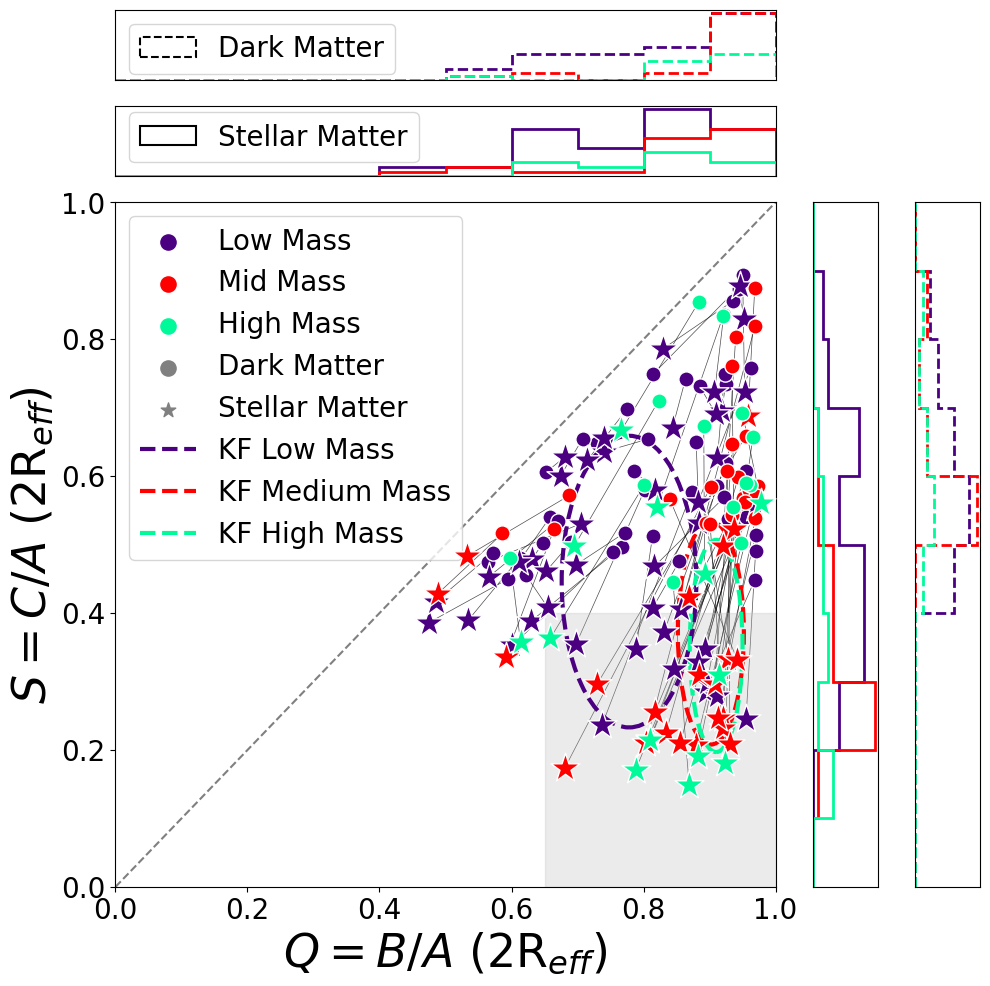

In [137]:

import PlotClasses
#display classes in PlotClasses
#print(dir(PlotClasses))
#reload(PlotClasses)
importlib.reload(PlotClasses)
importlib.reload(sdt)

feedbacks = ['BWMDC', 'MerianCDM']
for reff_multi in [2]:
    B_s,C_s,T_s,B_d,C_d,T_d,masses,mb,mb_reff,mb_10rvir,htype,reff,mvir,feedback_type,sims,hids,mergers,rvir,diffs_at_reff, jz_jcirc_avgs,t_dyn = sdt.LoadSimData(feedbacks,return_sims=True,reff_multi=reff_multi)

    #split into 3 mass bins 7-8.5, 8.5-9, 9-9.6
    
    lmask = (masses > 6) & (masses < 8.5)
    mmask = (masses > 8.5) & (masses < 9)
    hmask = (masses > 9) & (masses < 10)     

    #Usage example:
    folder = '/home/bk639/OverLeaf/ShapePaper/figures/'
    data_plot = {
        'B_s': B_s, 'C_s': C_s, 'T_s': T_s, 'B_d': B_d, 'C_d': C_d, 'T_d': T_d,
        'masses': masses, 'mb': mb, 'htype': htype, 'reff': reff, 'mvir': mvir,'reff_multi':reff_multi,
        'diffs_at_reff': diffs_at_reff, 'halo_id': hids

    }
    masks = {'low_mass': lmask, 'mid_mass': mmask, 'high_mass': hmask}
    labels = {'low_mass': 'Low Mass', 'mid_mass': 'Mid Mass', 'high_mass': 'High Mass', 'B': 'Q', 'C': 'S'}
    colors = {'low_mass': 'indigo', 'mid_mass': 'red', 'high_mass': 'mediumspringgreen'}


    #save data and masks to pickle file
    with open(f'../../Data/BasicData/3DShapesData.{reff_multi}.pickle', 'wb') as f:
        pickle.dump((data_plot, masks, labels), f)


    plotter = PlotClasses.GeneralPlotter(data_plot, masks, labels, colors)
    plotter.plot_KF_data = True    
    plotter.plot_data_with_masks('B', 'C', show_lines=True, show_scatter=True, filename=folder +  f'SvQ_massbin.{reff_multi}.png')
    #on top of this, plot the mean values of B, C, for each mass bin
    
    
    #plotter.calculate_shape_diff()
    # plotter.plot_triaxiality_vs_mass(filename=folder + f'T_vs_Mass_disky.{reff_multi}.png')
    #plotter.plot_T_stellar_vs_dark(filename=folder + f'T_stellar_vs_dark_matter_disky.{reff_multi}.png')
    #plotter.plot_Mstar_V_b_d_b_s_V_c_d_c_s(filename= folder + f'Mstar_V_b_d_b_s_V_c_d_c_s_disky.{reff_multi}.png')
    #plotter.plot_q_s_q_d(filename=folder + f'q_s_q_d_and_s_s_s_d.{reff_multi}.png')
    #plotter.plot_Mstar_V_QvS(filename=folder + f'Mstar_V_QvS_disky.{reff_multi}.png')
    #plotter.plot_triaxiality_histograms(filename=folder + f'Triaxiality_histograms_disky.{reff_multi}.png')
    #if reff_multi == 2:
    #    plotter.plot_angle_distributions(filename=folder + f'angle_distributions.{reff_multi}.png')









In [ ]:
print(np.mean(halo_differences['C_s_diff']))

In [ ]:
#remove first column of feedback_statistics
feedback_statistics = feedback_statistics.drop(columns='feedback_type')
#remove any _std columns
feedback_statistics = feedback_statistics.loc[:, ~feedback_statistics.columns.str.contains('std')]

feedback_statistics.diff()


In [ ]:


import PlotClasses
#display classes in PlotClasses
#print(dir(PlotClasses))
#reload(PlotClasses)
importlib.reload(PlotClasses)
importlib.reload(sdt)
feedbacks = ['BWMDC', 'SBMarvel']




for reff_multi in [1]:
    B_s,C_s,T_s,B_d,C_d,T_d,masses,mb,mb_reff,mb_10rvir,htype,reff,mvir,feedback_type,sims,hids,mergers,rvir,diffs_at_reff, jz_jcirc_avgs,t_dyn = sdt.LoadSimData(feedbacks,return_sims=True,reff_multi=reff_multi,fixed_r=False)

    mask = ((sims == 'storm') & (hids != 31))

    B_s = B_s[mask]
    C_s = C_s[mask]
    T_s = T_s[mask]
    B_d = B_d[mask]
    C_d = C_d[mask]
    T_d = T_d[mask]
    masses = masses[mask]
    mb = mb[mask]
    mb_reff = mb_reff[mask]
    mb_10rvir = mb_10rvir[mask]
    htype = htype[mask]
    reff = reff[mask]
    mvir = mvir[mask]
    feedback_type = feedback_type[mask]
    sims = sims[mask]
    hids = hids[mask]
    #mergers = mergers[~mask]
    rvir = rvir[mask]
    diffs_at_reff = diffs_at_reff[mask]
    jz_jcirc_avgs = jz_jcirc_avgs[mask]
    t_dyn = t_dyn[mask]
    #print(len(sims))

    #for each feedback type, print reff
    for halo in np.unique(hids):
        print(halo)
        mask = hids == halo

        print(f'masses: {masses[mask]}')
        print(f'reff: {reff[mask]}')
        print(f'mvir: {mvir[mask]}')
        print(f'rvir: {rvir[mask]}')
        #print differences in B, C, T between feedback types
        if np.sum(mask) == 2:
            B_s_diff = (B_s[mask][0] - B_s[mask][1])
            print(f'B_s diff: {B_s_diff}')
            C_s_diff = (C_s[mask][0] - C_s[mask][1])
            print(f'C_s diff: {C_s_diff}')
            T_s_diff = (T_s[mask][0] - T_s[mask][1])
            print(f'T_s diff: {T_s_diff}')
            B_d_diff = (B_d[mask][0] - B_d[mask][1])
            print(f'B_d diff: {B_d_diff}')
            C_d_diff = (C_d[mask][0] - C_d[mask][1])
            print(f'C_d diff: {C_d_diff}')
            T_d_diff = (T_d[mask][0] - T_d[mask][1])
            print(f'T_d diff: {T_d_diff}')
            print('')
    #display differences in B, C, T between feedback types averaged
    for feedback in feedbacks:
        mask = feedback_type == feedback
        print(feedback)
        print(f'B_s mean: {np.mean(B_s[mask])}, std: {np.std(B_s[mask])}')
        print(f'C_s mean: {np.mean(C_s[mask])}, std: {np.std(C_s[mask])}')
        print(f'T_s mean: {np.mean(T_s[mask])}, std: {np.std(T_s[mask])}')
        print(f'B_d mean: {np.mean(B_d[mask])}, std: {np.std(B_d[mask])}')
        print(f'C_d mean: {np.mean(C_d[mask])}, std: {np.std(C_d[mask])}')
        print(f'T_d mean: {np.mean(T_d[mask])}, std: {np.std(T_d[mask])}')
        print('')








    mask = np.zeros(len(sims), dtype=bool)






    #Usage example:
    folder = '/home/bk639/MorphologyMeasurements/figures/SBMarvel/'
    superbubble_mask = feedback_type == 'SBMarvel'
    data_plot = {
        'B_s': B_s, 'C_s': C_s, 'T_s': T_s, 'B_d': B_d, 'C_d': C_d, 'T_d': T_d,
        'masses': masses, 'mb': mb, 'htype': htype, 'reff': reff, 'mvir': mvir,'reff_multi':reff_multi
    }
    masks = {'BW': ~superbubble_mask, 'SB': superbubble_mask}
    labels = {'BW': 'BW', 'SB': 'SB', 'B': 'Q', 'C': 'S'}
    colors = {'BW': 'k', 'SB': 'red'}

    plotter = PlotClasses.GeneralPlotter(data_plot, masks, labels, colors)
    plotter.plot_data_with_masks('B', 'C', show_lines=True, show_scatter=True, filename=folder +  f'SvQ_disky.{reff_multi}.png')
    plotter.calculate_shape_diff()
    plotter.plot_triaxiality_vs_mass(filename=folder + f'T_vs_Mass_disky.{reff_multi}.png')
    plotter.plot_T_stellar_vs_dark(filename=folder + f'T_stellar_vs_dark_matter_disky.{reff_multi}.png')
    plotter.plot_Mstar_V_b_d_b_s_V_c_d_c_s(filename= folder + f'Mstar_V_b_d_b_s_V_c_d_c_s_disky.{reff_multi}.png')
    plotter.plot_q_s_q_d(filename=folder + f'q_s_q_d_and_s_s_s_d.{reff_multi}.png')



In [ ]:
import PlotClasses
#display classes in PlotClasses
#print(dir(PlotClasses))
#reload(PlotClasses)
importlib.reload(PlotClasses)
#Usage example:
folder = '/home/bk639/OverLeaf/ShapePaper/figures/'
filename = 'SvQ.png'
data_plot = {
    'B_s': B_s, 'C_s': C_s, 'T_s': T_s, 'B_d': B_d, 'C_d': C_d, 'T_d': T_d,
    'masses': masses, 'mb': mb, 'htype': htype, 'reff': reff, 'mvir': mvir
}
mask = np.ones(len(sims),dtype=bool)
#all data
masks = {'all': mask}
labels = {'all': '', 'B': 'Q', 'C': 'S'}
colors = {'all': 'k'}



plotter = PlotClasses.GeneralPlotter(data_plot, masks, labels, colors)
plotter.plot_data_with_masks('B', 'C', show_lines=True, show_scatter=True, filename=folder + filename)
plotter.calculate_shape_diff()
plotter.plot_triaxiality_vs_mass(filename=folder + 'T_vs_Mass.png')
plotter.plot_T_stellar_vs_dark(filename=folder + 'T_stellar_vs_dark_matter.png')
#plotter.plot_Mstar_V_b_d_b_s_V_c_d_c_s(filename= folder + 'Mstar_V_b_d_b_s_V_c_d_c_s_disky.png')

In [ ]:
#recreate previous plots only for feedback type MerianCDM only split into disk and non-disk galaxies
folder = '/home/bk639/OverLeaf/ShapePaper/figures/'
filename = 'SvQ_MerianCDM.png'
feedback_type_mask = feedback_type == 'MerianCDM'
data_plot = {
    'B_s': B_s, 'C_s': C_s, 'T_s': T_s, 'B_d': B_d, 'C_d': C_d, 'T_d': T_d,
    'masses': masses, 'mb': mb_reff, 'htype': htype, 'reff': reff, 'mvir': mvir
}

print(len(feedback_type_mask))
for key in data_plot.keys():
    data_plot[key] = data_plot[key][feedback_type_mask]
disk_mask = disk_mask[feedback_type_mask]
ellip_mask = ellip_mask[feedback_type_mask]
masks = {'disky': disk_mask, 'non-disky': ~disk_mask}
labels = {'disky': 'Disky', 'non-disky': 'Non-Disky', 'B': 'Q', 'C': 'S'}
colors = {'disky': 'green', 'non-disky': 'k'}


In [ ]:
importlib.reload(PlotClasses)
plotter = PlotClasses.GeneralPlotter(data_plot, masks, labels, colors)
plotter.plot_data_with_masks('B', 'C', show_lines=True, show_scatter=True, filename=folder + filename)
plotter.calculate_shape_diff()
plotter.plot_triaxiality_vs_mass(filename=folder + 'T_vs_Mass_disky_Merian.png')
plotter.plot_T_stellar_vs_dark(filename=folder + 'T_stellar_vs_dark_matter_disky.png')

In [ ]:
#reload PlotClasses
importlib.reload(PlotClasses)

plotter.plot_Mstar_V_b_d_b_s_V_c_d_c_s()

In [ ]:

#plot B_dm/B_star and C_dm/C_star
fig, ax = plt.subplots(1, 2, figsize=(20, 12), sharey=True)
#share y axis
ax[0].set_ylim([0.5, 2.5])

ax[0].scatter(data_plot['masses'][disk_mask], data_plot['B_s'][disk_mask]/data_plot['B_d'][disk_mask], label='Disky', color='g')
ax[0].scatter(data_plot['masses'][ellip_mask], data_plot['B_s'][ellip_mask]/data_plot['B_d'][ellip_mask], label='Non-Disky', color='k')
ax[0].set_xlabel('Stellar Mass')
ax[0].set_ylabel('B_dm/B_star')
ax[0].legend()
ax[1].scatter(data_plot['masses'][disk_mask], data_plot['C_d'][disk_mask]/data_plot['C_s'][disk_mask], label='Disky', color='g')
ax[1].scatter(data_plot['masses'][ellip_mask], data_plot['C_d'][ellip_mask]/data_plot['C_s'][ellip_mask], label='Non-Disky', color='k')
ax[1].set_xlabel('Stellar Mass')
ax[1].set_ylabel('C_dm/C_star')
ax[1].legend()

data_plot['B_dm/B_star'] = data_plot['B_s']/data_plot['B_d']
data_plot['C_dm/C_star'] = data_plot['C_d']/data_plot['C_s']

#sns.regplot(x = data_plot['masses'][disk_mask], y = data_plot['B_dm/B_star'][disk_mask], ax = ax[0], color = 'b',)
#sns.regplot(x = data_plot['masses'][ellip_mask], y = data_plot['B_dm/B_star'][ellip_mask], ax = ax[0], color = 'r', )
#sns.regplot(x = data_plot['masses'][disk_mask], y = data_plot['C_dm/C_star'][disk_mask], ax = ax[1], color = 'b',)
#sns.regplot(x = data_plot['masses'][ellip_mask], y = data_plot['C_dm/C_star'][ellip_mask], ax = ax[1], color = 'r',)

#add grid
ax[0].grid()
ax[1].grid()

#all data fit
#sns.regplot(x = data_plot['masses'], y = data_plot['B_dm/B_star'], ax = ax[0])
#sns.regplot(x = data_plot['masses'], y = data_plot['C_dm/C_star'], ax = ax[1])




#share y axis





In [ ]:

#create histogram of diffs_at_reff for disky and non-disky
fig, ax = plt.subplots(3, 1, figsize=(6, 8))
bins = np.linspace(0, 90, 10)
angle_labels = ['A', 'B', 'C']
for i in range(3):
    ax[i].hist(diffs_at_reff[:, i][disk_mask], bins=bins, alpha=.5, label='Disky', color='g', histtype='step', lw=2)
    ax[i].hist(diffs_at_reff[:, i][ellip_mask], bins=bins, alpha=.5, label='Non-Disky', color='k', histtype='step', lw=2)
    ax[i].set_title(f'Angular Difference in {angle_labels[i]} axis')
    print(np.sum(diffs_at_reff[:, i] < 30) / len(diffs_at_reff[:, i][disk_mask]))

plt.subplots_adjust(hspace=0.5)  # Adjust the spacing between plots
plt.show()

#recreate plot but with only galaxies that low diffs_at_reff[:,2] < 10
fig, ax = plt.subplots(3, 1, figsize=(6, 8))
bins = np.linspace(0, 90, 10)
angle_labels = ['A', 'B', 'C']
filter = diffs_at_reff[:, 2] < 10
for i in range(3):
    ax[i].hist(diffs_at_reff[:, i][disk_mask & filter], bins=bins, alpha=.5, label='Disky', color='g', histtype='step', lw=2)
    ax[i].hist(diffs_at_reff[:, i][ellip_mask & filter], bins=bins, alpha=.5, label='Non-Disky', color='k', histtype='step', lw=2)
    ax[i].set_title(f'Angular Difference in {angle_labels[i]} axis')
    print(np.sum(diffs_at_reff[:, i] < 10) / len(diffs_at_reff[:, i][disk_mask]))

plt.subplots_adjust(hspace=0.5)  # Adjust the spacing between plots

plt.show()

In [ ]:

#print number of galaxies with angular difference less than 30 degrees for disky and non-disky
#for each angle component
cutoff = 10
for i in range(3):
    print(i)
    print(f'Number of galaxies with angular difference less than {cutoff} degrees for disky in axis        |: {np.sum(diffs_at_reff[:, i][disk_mask] < cutoff)} out of {sum(disk_mask)}')
    print(f'Number of galaxies with angular difference less than {cutoff} degrees for non-disky in axis    |: {np.sum(diffs_at_reff[:, i][ellip_mask] < cutoff)} out of {sum(ellip_mask)}')
    print(f'Number of galaxies with angular difference less than {cutoff} degrees for all galaxies in axis |: {np.sum(diffs_at_reff[:, i] < cutoff)} out of {len(diffs_at_reff[:, i])}')





In [ ]:

folder = '/home/bk639/OverLeaf/ShapePaper/figures/'
filename = 'SvQ_plain.png'
feedback_type_mask = feedback_type == 'MerianCDM'
labels = {'MerianCDM': 'Merians', 'BWMDC': 'Marvel + DCJL', 'B': 'Q', 'C': 'S'}
# colors = {'MerianCDM': 'r', 'BWMDC': 'b'}
# masks = {'MerianCDM': feedback_type_mask, 'BWMDC': ~feedback_type_mask}
colors = {'Full Sample': 'k'}
masks = {'Full Sample': np.ones(len(feedback_type),dtype=bool)}
labels = {'Full Sample': 'All', 'B': 'Q', 'C': 'S'}

#print sample stats.
#total number of galaxies
print(f'Total number of galaxies: {len(feedback_type)}')
#number of MerianCDM galaxies
print(f'Number of MerianCDM galaxies: {np.sum(feedback_type == "MerianCDM")}')
#number of BWMDC galaxies
print(f'Number of BWMDC galaxies: {np.sum(feedback_type == "BWMDC")}')

#number of marvel galaxies with sim names cptmarvel, storm, rogue, elektra
print(f'Number of Marvel galaxies: {np.sum(marvel_mask)}')
#number of DCJL galaxies with sim names h148, h229, h242, h329
print(f'Number of DCJL galaxies: {np.sum(DCJL_mask)}')

#number of satellites and centrals
print(f'Number of satellites: {np.sum(htype == "v")}')
print(f'Number of centrals: {np.sum(htype == "o")}')
#number of disk galaxies
print(f'Number of disk galaxies: {np.sum(disk_mask)}')
#number of elliptical galaxies
print(f'Number of elliptical galaxies: {np.sum(ellip_mask)}')
#number of irregular galaxies
print(f'Number of irregular galaxies: {np.sum(irr_mask)}')

print(f'Number of Merging galaxies in the last 700Myr: {4}')

#print range of dynamical times of merging galaxies r615 halo 1 , r618 halo 1, elektra halo 3, storm halo 4, rogue halo 1, h148 halo 3
merging_galaxies = {'r615': 1, 'r618': 1, 'elektra': 3, 'storm': 4, 'rogue': 1, 'h148': 3}
for sim, halo in merging_galaxies.items():
    indices = (sims == sim) & (hids == halo)
    print(f'{sim} halo {halo} has dynamical time of {t_dyn[indices][0]*1000:.2f} Myr')

#print range of all dynamical times
print(f'Minimum dynamical time: {np.min(t_dyn)*1000:.2f} Myr')
print(f'Maximum dynamical time: {np.max(t_dyn)*1000:.2f} Myr')



In [ ]:
print(sims)

In [ ]:

sim = 'r615'
halo = 1
indices = (sims == sim) & (hids == halo)
#print stellar mass, virial mass, dynamical time, virial radius, effective radius, baryonic fraction within virial radius, baryonic fraction within effective radius
print(f'{sim} halo {halo} has stellar mass of {masses[indices]}, virial mass of {mvir[indices]}, dynamical time of {t_dyn[indices]}, virial radius of {rvir[indices]}, effective radius of {reff[indices]}, baryonic fraction within virial radius of {mb[indices]}, baryonic fraction within effective radius of {mb_reff[indices]}')


In [ ]:
sim = 'r618'
halo = 1
indices = (sims == sim) & (hids == halo)
#print stellar mass, virial mass, dynamical time, virial radius, effective radius, baryonic fraction within virial radius, baryonic fraction within effective radius
print(f'{sim} halo {halo} has stellar mass of {masses[indices]}, virial mass of {mvir[indices]}, dynamical time of {t_dyn[indices]}, virial radius of {rvir[indices]}, effective radius of {reff[indices]}, baryonic fraction within virial radius of {mb[indices]}, baryonic fraction within effective radius of {mb_reff[indices]}')


In [ ]:

plotter = PlotClasses.GeneralPlotter(data, masks, labels, colors)
plotter.plot_data_with_masks('B', 'C', show_lines=True, show_scatter=True, filename=folder + filename)
plotter.calculate_shape_diff()
plotter.plot_triaxiality_vs_mass(filename=folder + 'T_vs_Mass.png')
plotter.plot_T_stellar_vs_dark(filename=folder + 'T_stellar_vs_dark_matter.png')
plotter.calculate_shape_diff()



In [ ]:
folder = '/home/bk639/OverLeaf/ShapePaper/figures/'
filename = 'SvQ_sat.png'
sattellite_mask = htype == 'o'
labels = {'sattellite': 'Sattellite', 'central': 'Central', 'B': 'Q', 'C': 'S'}
colors = {'sattellite': 'gray', 'central': 'orange'}
masks = {'sattellite': sattellite_mask, 'central': ~sattellite_mask}


plotter = PlotClasses.GeneralPlotter(data, masks, labels, colors)
plotter.plot_data_with_masks('B', 'C', show_lines=True, show_scatter=True, filename=folder + filename)
plotter.calculate_shape_diff()
plotter.plot_triaxiality_vs_mass()
plotter.calculate_shape_diff()


In [ ]:

import importlib
importlib.reload(sdt)
sdt.MvC_diffBdiff_disks(B_s, C_s, T_s, B_d, C_d, T_d, masses, mb, htype, reff, mvir, feedback_type, disk_mask, mergers=None)

In [ ]:
#load pickle files f'../../Data/MergerShapes.{feedback}.pickle', 'wb'))
feedbacks = ['MerianCDM']
fig,ax = plt.subplots(1,1,figsize=(8,8))
for feedback in feedbacks:
    mergers = pickle.load(open(f'../../Data/MergerShapes.{feedback}.pickle', 'rb'))
    for sim in mergers:
        for halo in mergers[sim]:
            colors = ['r','b','g']
            for snapshot,color in zip(mergers[sim][halo],colors):
                B_s = mergers[sim][halo][snapshot]['ba_s_smoothed_at_Reff']
                C_s = mergers[sim][halo][snapshot]['ca_s_smoothed_at_Reff']
                B_d = mergers[sim][halo][snapshot]['ba_d_smoothed_at_Reff']
                C_d = mergers[sim][halo][snapshot]['ca_d_smoothed_at_Reff']
                T_s = T(B_s,C_s)
                T_d = T(B_d,C_d)
                ax.scatter(B_s,C_s,c=color,marker='*',label='Stellar')
                ax.scatter(B_d,C_d,c=color,marker='o',label='Dark Matter')
                ax.plot([B_s,B_d],[C_s,C_d],c=color)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('B/A')
ax.set_ylabel('C/A')
ax.set_title('Merger Shapes')
ax.legend()
plt.show()

                
                

In [ ]:
print(sims)

In [ ]:
distances = np.sqrt((B_d - B_s)**2 + (C_d - C_s)**2)
T_diff = T_d - T_s
print('all data')
mean_T_diff, std_T_diff, mean_distances, std_distances = sdt.analyze_distances(T_diff, distances, condition=None)
print('disky')
mean_T_diff, std_T_diff, mean_distances, std_distances = sdt.analyze_distances(T_diff, distances, condition=mask)
print('non-disky')
mean_T_diff, std_T_diff, mean_distances, std_distances = sdt.analyze_distances(T_diff, distances, condition=~mask)

In [ ]:
import importlib
importlib.reload(sdt)


#sdt.plot_data(B_s, C_s, T_s, B_d, C_d, T_d, masses, mb, htype, reff, mvir, feedback_type,condition=None)


In [ ]:


print((mask))

# B_s,C_s,T_s,B_d,C_d,T_d,masses,mb,htype,reff,mvir,feedback_type,sims,hids,mergers = B_s[~mask],C_s[~mask],T_s[~mask],B_d[~mask],C_d[~mask],T_d[~mask],masses[~mask],mb[~mask],htype[~mask],reff[~mask],mvir[~mask],feedback_type[~mask],sims[~mask],hids[~mask],mergers[~mask]



In [ ]:
print(mergers.shape)
#print non [[nan, nan ]] mergers
# but do print [[nan, float]] mergers
print(mergers[~np.isnan(mergers).all(axis=2)])


In [ ]:
import importlib
importlib.reload(sdt)
from StellarDMTracing import colors

In [ ]:
plt.style.use('default')
sdt.T_vs_Mstar(T_d,T_s,masses,mb_reff,htype,feedback_type)


In [ ]:
sdt.plot_data(B_s, C_s, T_s, B_d, C_d, T_d, masses, mb, htype, reff, mvir, feedback_type,mergers,show_lines=True) 


In [ ]:
sdt.T_vs_Tdm(T_d, T_s,masses,htype,feedback_type,legend = ['Marvel+DCJL','Merians'],label = 'CDM')

In [ ]:
plt.style.use('default')

def axis_difference(d,s):
    #absolote difference
    #return d-s
    #relative difference
    avg = np.average([d, s], axis=0)
    #return (d-s)/avg
    #ratio
    return d/s

fig,axes = plt.subplots(1,2,figsize=(20,10))
ax = axes[0]
#ax.set_ylim([.4,2.4])

c_ratio = axis_difference(C_d,C_s)
# now plotting ratio of C_d/C_s
ylabel = r'$C_{DM}/C_{*}$'
#ylabel = r'$\Delta C = \frac{C_{DM} - C_{*}}{\bar{C}}$'
sdt.plot_DM_S_axes_diffs(ax,c_ratio,masses,feedback_type,ylabel)

axes[1].sharey(axes[0])

ax=axes[1]
b_ratio = axis_difference(B_d,B_s)
ylabel = r'$B_{DM}/B_{*}$'
#ylabel = r'$\Delta B = \frac{B_{DM} - B_{*}}{\bar{B}}$'

import seaborn as sns

def plot_DM_S_axes_diffs(ax,c_diff,masses,feedback_type,ylabel):

    ax.scatter(masses[feedback_type == 'MerianCDM'], c_diff[feedback_type == 'MerianCDM'], label='Merians')
    #ax.scatter(masses[feedback_type == 'BWMDC'], c_diff[feedback_type == 'BWMDC'], label='Marvel+DCJL',
     #          c=colors['BWMDC'])
    # plot y = 0 line
    ax.axhline(1, c='k', linestyle='-', alpha=.5)
    ax.set_xlabel(r'Log(M$_*$/M$_\odot$)', fontsize=25)
    ax.set_ylabel(ylabel, fontsize=25)
    ax.legend(loc='upper left', prop={'size': 20})
    # linear fit and show error on plot
    # increase tick size and font
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=15)

    # sns.regplot(x=masses[feedback_type=='MerianCDM'],y=c_diff[feedback_type=='MerianCDM'],ax=ax,scatter=False)
    # sns.regplot(x=masses[feedback_type=='BWMDC'],y=c_diff[feedback_type=='BWMDC'],ax=ax,scatter=False)
    sns.regplot(x=masses, y=c_diff, ax=ax, scatter=False, color='k', label='Linear Fit')
    # get linear fit parameters using scipy.stats.linregress
    from scipy.stats import linregress
    LinregressResult = linregress(masses, c_diff)
    slope = LinregressResult.slope
    intercept = LinregressResult.intercept
    rv = LinregressResult.rvalue
    pval = LinregressResult.pvalue
    stderr = LinregressResult.stderr
    intercept_stderr = LinregressResult.intercept_stderr
    print(
        f'slope: {slope}, intercept: {intercept}, r: {rv}, pval: {pval}, stderr: {stderr}, intercept_stderr: {intercept_stderr}')

    # plot linear fit
    x = np.linspace(6, 9.5, 100)
    y = slope * x + intercept
    # ax.plot(x,y,c='k',linestyle='--',label='Linear Fit')
    # add confidence interval from both slope error and intercept error


#ax.text(6.5,.2,r'$\Delta C = {slope:.2f}M_* + {intercept:.2f}$',fontsize=15)
fig.savefig(f'../../Figures/3DShapes/MvC_diff.png',bbox_inches='tight',pad_inches=.1,dpi = 300)

#create a similar plot but instead of mass use m_b/m_vir within Reff as x axis
#also try plotting disky vs nondisky for colors instead of feedback type
#change labels to Q and S instead of B and C






In [ ]:
plot_DM_S_axes_diffs(ax,b_ratio,masses,feedback_type,ylabel)

In [ ]:
import astropy
#test astropy
print(astropy.__version__)

In [ ]:
from astropy import units as u
from astropy import constants as const
import numpy as np

def calculate_dynamical_time(r_vir, M_halo):
    # Convert input parameters to Astropy quantities
    r_vir = r_vir * u.kpc
    M_halo = M_halo * u.solMass
    r_vir = r_vir.to(u.kpc)
    M_halo = M_halo.to(u.solMass)

    # Calculate dynamical time
    t_dyn = np.sqrt(r_vir**3 / (const.G * M_halo))

    return t_dyn.to(u.Gyr)


t_dyn = []
# Calculate dynamical time for each galaxy
for i in range(len(rvir)):
    r_vir = rvir*10
    M_halo = mvir[i]
    t = calculate_dynamical_time(r_vir, M_halo)
    print(f'r_vir: {r_vir:.2f}, M_halo: {M_halo:.2e}, t_dyn: {t:.2f}')
    t_dyn.append(t.value)

In [ ]:
print(t_dyn)

In [ ]:

#get avg, std, min, max
t_dyn = np.array(t_dyn)
print(f'Average dynamical time: {np.mean(t_dyn):.2f}')
print(f'Standard deviation of dynamical time: {np.std(t_dyn):.2f}')
print(f'Minimum dynamical time: {np.min(t_dyn):.2f}')
print(f'Maximum dynamical time: {np.max(t_dyn):.2f}')





In [ ]:
mask = abs(T_d - T_s) < .05
#print(sum(mask))

#print(T_d[mask],T_s[mask],T_d[mask]-T_s[mask])

#look for repeated values in T_d and T_s
for i in range(len(T_d)):
    for j in range(i+1,len(T_d)):
        if T_d[i] == T_d[j] or T_s[i] == T_s[j]:
            print(i,j)
            print(T_d[i],T_s[i],T_d[j],T_s[j])




In [ ]:
SimFilePath = ['../PickleFiles/SimulationInfo.MerianCDM.pickle','../PickleFiles/SimulationInfo.MerianSIDM.pickle']
MassPath = ['../../Data/BasicData/MerianCDM.Masses.pickle','../../Data/BasicData/MerianSIDM.Masses.pickle']
HaloTypePath = ['../../Data/BasicData/HaloTypes.MerianCDM.txt','../../Data/BasicData/HaloTypes.MerianSIDM.txt']
feedback = ['MerianCDM','MerianSIDM']
B_s,C_s,T_s,B_d,C_d,T_d,masses,mb,htype,reff,mvir,feedback_type,sims = sdt.LoadSimData(SimFilePath,MassPath,HaloTypePath,feedback,return_sims=True)

#main(B_s,C_s,T_s,B_d,C_d,T_d,masses,mb,htype,reff,mvir,feedback_type,r[i])

In [ ]:
sdt.plot_SIDM_CDM(B_s,C_s,T_s,B_d,C_d,T_d,masses,mb,htype,reff,mvir,feedback_type,sims)

In [ ]:
plt.rcParams['font.family'] = 'DejaVu Sans'

dpi = 300


#Convert lists to arrays for htype indexing
T_d,T_s,masses,mb,htype = np.array(T_d),np.array(T_s),np.array(masses),np.array(mb),np.array(htype)
B_s,C_s,B_d,C_d = np.array(B_s),np.array(C_s),np.array(B_d),np.array(C_d)

#T* vs Tdm
f,ax = plt.subplots(1,1,figsize=(5,5))
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.fill_between([0,1],[-1/3,2/3],[1/3,4/3],color='0.75',alpha=.3)
ax.plot([0,1],[0,1],c='0.5',linestyle='--')
ax.set_ylabel(r'T$_*$',fontsize=15)
ax.set_xlabel(r'T$_{DM}$',fontsize=15)

norm = plt.Normalize(int(min(masses)),int(max(masses))+.1)
p = ax.scatter(T_d[htype=='o'],T_s[htype=='o'],marker='o',c=masses[htype=='o'],cmap='viridis',norm=norm)
ax.scatter(T_d[htype=='v'],T_s[htype=='v'],marker='v',c=masses[htype=='v'],cmap='viridis',norm=norm,label='Satellites')
cbar = f.colorbar(p,cax=f.add_axes([.91,.11,.03,.77]))
cbar.set_label(r'Log(M$_*$/M$_\odot$)',fontsize=15)

ax.legend(loc='lower left',prop={'size':12})
f.savefig(f'../../Figures/3DShapes/T_Comparison.png',bbox_inches='tight',pad_inches=.1,dpi = dpi)

In [ ]:
#B/A vs C/A links
f,ax = plt.subplots(1,1,figsize=(5,5))
ax.set_xlim([0,1])
ax.set_ylim([0,1])
#ax.fill_between([0,1],[-.1,.9],[.1,1.1],color='0.75',alpha=.3)
ax.plot([0,1],[0,1],c='0.5',linestyle='--')
ax.set_xlabel(r'$S$',fontsize=20)
ax.set_ylabel(r'$Q$',fontsize=20)
ax.tick_params(which='both',labelsize=15)
ax.scatter(-1,-1)

for i in np.arange(len(B_s)):
    ax.plot([B_s[i],B_d[i]],[C_s[i],C_d[i]],c='.5',zorder=0)

f.savefig(f'../../Figures/3DShapes/CvB.LinksOnly.png',bbox_inches='tight',pad_inches=.1)

ax.scatter(B_d[htype=='o'],C_d[htype=='o'],c='k',label='Dark Matter')
ax.scatter(B_d[htype=='v'],C_d[htype=='v'],c='k',marker='v')
ax.scatter(B_s[htype=='o'],C_s[htype=='o'],c='r',label='Stellar')
ax.scatter(B_s[htype=='v'],C_s[htype=='v'],c='r',marker='v')
ax.scatter(-1,-1,c='.5',marker='v',label='Satellites')

ax.legend(loc='upper left',prop={'size':15})
f.savefig(f'../../Figures/3DShapes/CvB.Links.png',bbox_inches='tight',pad_inches=.1,dpi = dpi)

In [ ]:
import matplotlib.font_manager
fonts = matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
print([matplotlib.font_manager.FontProperties(fname=f).get_name() for f in fonts])


In [ ]:
import matplotlib.font_manager
matplotlib.font_manager._load_fontmanager(try_read_cache=False)

In [ ]:
#create contour plot of triaxiality on a B/A vs Q/A plot
#create meshgrid for B/A and Q/A
B = np.linspace(0,.999,100)
C = np.linspace(0,.999,100)
B,C = np.meshgrid(B,C)
#remove points where C > B
mask = C > B
B[mask] = np.nan
C[mask] = np.nan

T_c = T(B,C)


In [ ]:
#create colored contour plot
f,ax = plt.subplots(1,1,figsize=(8,8))
ax.set_xlim([0,1])
ax.set_ylim([0,1])
#ax.fill_between([0,1],[-.1,.9],[.1,1.1],color='0.75',alpha=.3)
#ax.plot([0,1],[0,1],c='0.5',linestyle='--')
ax.set_xlabel(r'$S=B/A$',fontsize=20)
ax.set_ylabel(r'$Q=C/A$',fontsize=20)
ax.tick_params(which='both',labelsize=15)
ax.scatter(-1,-1)
ax.contourf(B,C,T_c,cmap='viridis',levels=100)
#add labeled contour lines as T = .33,.66 with inline labels
CS = ax.contour(B,C,T_c,levels=[1/3,2/3],colors='k')
labels = ['T = 1/3','T = 2/3']
fmt = {}

for l, s in zip(CS.levels, labels):
    fmt[l] = s
ax.clabel(CS, inline=True, fontsize=10, fmt=fmt)
ax.set_aspect('equal')


#add colorbar for T
norm = plt.Normalize(0,1)
cbar = f.colorbar(plt.cm.ScalarMappable(norm=norm,cmap='viridis'),cax=f.add_axes([.91,.11,.03,.77]))
cbar.set_label(r'Triaxiality',fontsize=15)

#add labels for oblate and prolate as lines
#oblate is T = 0 or vertical line at B = 1
ax.axvline(.995,c='orange',linestyle='dotted',label='Oblate',lw=5)

#prolate is T = 1 or 1-1 line
ax.plot([0,1],[0,1],c='k',linestyle='--',label='Prolate',lw=2)

#add label to near sphere
ax.scatter([.99],[.97],c='k',label='Near Sphere',s=100)

ax.legend(loc='upper left',prop={'size':15})




#add gridlines
ax.grid(True)
folder = '/home/bk639/OverLeaf/ShapePaper/figures/'
filename = 'TriaxialityContour.png'
f.savefig(folder + filename,bbox_inches='tight',pad_inches=.1,dpi = 300)





